# Deteccion Heterodina
## Hamiltoniano del sistema 
\begin{equation}
    H_{\text{sys}} = \Delta \, \sigma_+ \sigma_- + \frac{1}{2} \Omega \, (\sigma_+ + \sigma_-) 
\end{equation} 
## Hamiltoniano de la deteccion heterodina
\begin{equation}
    H_Z = H_{\text{sys}} + i \left( \gamma \langle \bar{\sigma}_+ \rangle_c + \sqrt{\gamma }\eta Z(t) \right) \sigma_-
\end{equation} 

## Incremento de Weiner complejo 
\begin{align}
    \eta Z &= \frac{dZ}{dt} \\
    dZ &= e^{i \omega' t} \, dW = \frac{1}{\sqrt{2}} \left( dW_1 + i \, dW_2 \right)
\end{align}

## Forma alternativa de las ecuaciones
\begin{equation}
    I_{Zc}(t) = \gamma \langle \bar{\sigma}_+ \rangle_c + \sqrt{\gamma \eta} \, Z
\end{equation}

\begin{equation}
    \frac{d|\Psi_c\rangle}{dt} = H_Z |\Psi_c\rangle
\end{equation}

\begin{equation}
    \frac{d|\Psi_c\rangle}{dt} = -i \left( H_{\text{sys}} + I_{Zc}(t) \sigma_- \right) |\Psi_c\rangle
\end{equation} 

In [18]:
steps = int(t_max / dt)

In [66]:
# Deteccion heterodina
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Parámetros
gamma = 1.0          # Tasa de detección
t_max = 50        # Tiempo de simulación
dt = 0.01            # Paso de tiempo
Omega = 3            # Frecuencia de Rabi
steps = int(t_max / dt)
Delta = 8          # Desintonía
num_traj = 10000     # Número de trayectorias


#Eficiencia del detector
eta=1

# Operadores cuánticos
sm = qt.destroy(2)    # σ-
sp = sm.dag()         # σ+
Pe = sp * sm          

# Hamiltoniano del sistema (Rabi) CORREGIDO
H_sys = Delta * sp * sm + 0.5 * Omega * (sp + sm) ##  [1]

# Función para una trayectoria estocástica con fase ϕ
def simulate_trajectory():
    
    psi_t = qt.basis(2, 0).unit()              # Estado inicial |g⟩
    pop_exc = []                               # Población del estado excitado
    photocurrent = []                          # Fotocorriente para esta trayectoria
    
    
    for i in range(steps):
        # Valor esperado de σ_ϕ
        
        dW1 = np.random.normal(0, np.sqrt(dt))
        dW2 = np.random.normal(0, np.sqrt(dt))
        dZ = (dW1 + 1j * dW2) / np.sqrt(2)
        eta_Z = dZ / (dt*eta)
        
        I_t = gamma * qt.expect(sp, psi_t) + np.sqrt(gamma) * eta_Z
        photocurrent.append(I_t)
        # Término de retroalimentación (depende de ϕ)
        H_feedback = 1j*I_t*sm 
        H_total = H_sys + H_feedback ## [2]
        
        # Evolución del estado
        dpsi = (-1j * H_total * psi_t) * dt
        psi_t = (psi_t + dpsi).unit()
        pop_exc.append(qt.expect(Pe, psi_t))
    
    return pop_exc, photocurrent


results = {}

# Arrays para almacenar resultados
trajectories_pop = np.zeros((num_traj, steps))
trajectories_I = np.zeros((num_traj, steps), dtype=np.complex128)

for k in range(num_traj):
    pop, I = simulate_trajectory()
    trajectories_pop[k, :] = pop
    trajectories_I[k, :] = I
    print(f"Simulacion DHt: Trayectoria {k+1}/{num_traj}", end="\r")

# Promedios
avg_pop = np.mean(trajectories_pop, axis=0)
avg_I = np.mean(trajectories_I, axis=0)

results = {
    'avg_pop': avg_pop,
    'avg_I': avg_I,
    'trajectories_I': trajectories_I  # Opcional: guardar todas las trayectorias
}



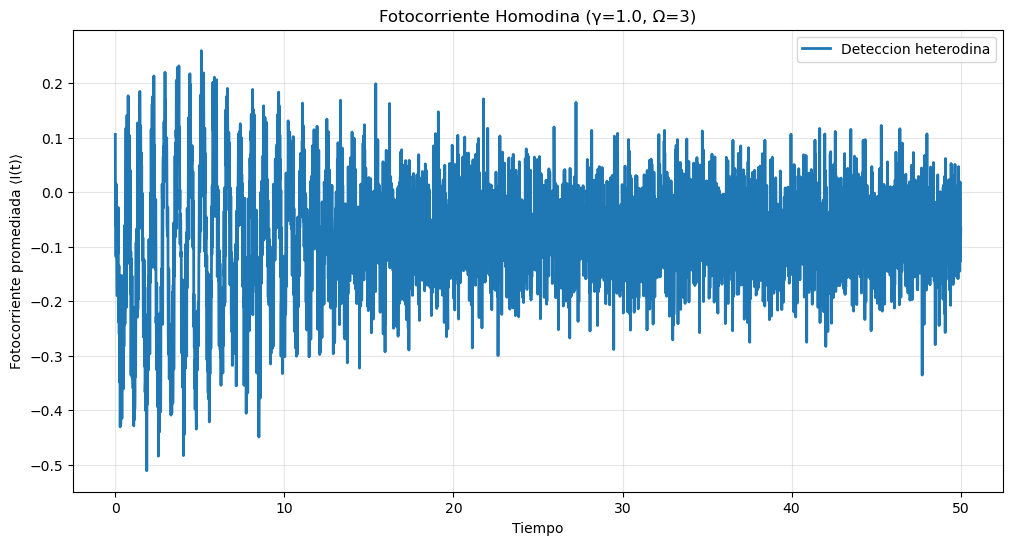

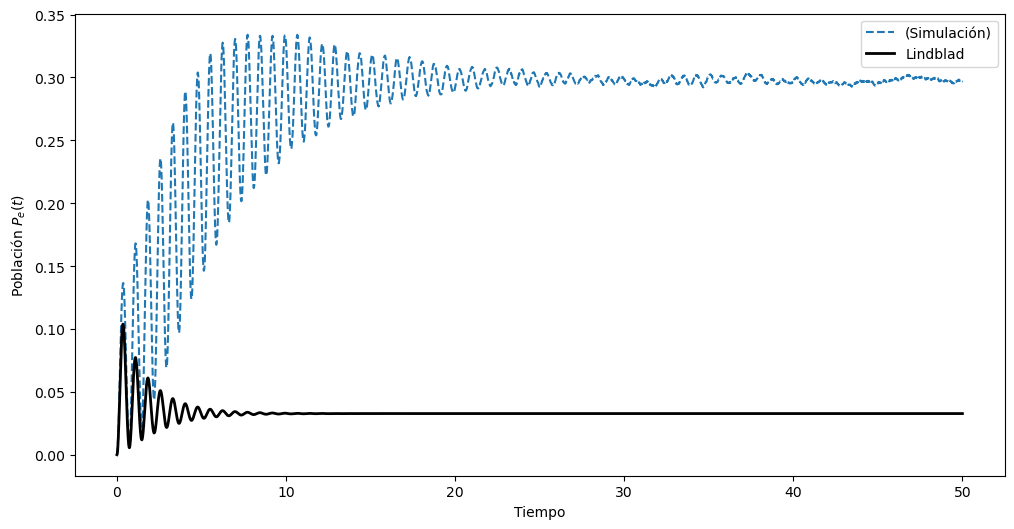

In [67]:
# Gráfico de fotocorrientes promediadas
plt.figure(figsize=(12, 6))
times = np.linspace(0, t_max, steps)
plt.plot(times, results['avg_I'], label="Deteccion heterodina", linewidth=2)
plt.xlabel("Tiempo")
plt.ylabel("Fotocorriente promediada ⟨I(t)⟩")
plt.title(f"Fotocorriente Homodina (γ={gamma}, Ω={Omega})")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Opcional: Comparar con ecuación maestra para P_e(t)
plt.figure(figsize=(12, 6))

plt.plot(times, results['avg_pop'], '--', label=f'(Simulación)')

# Ecuación maestra (solo una vez, pues no depende de ϕ)
c_ops = [np.sqrt(gamma) * sm]
rho0 = qt.ket2dm(qt.basis(2, 0))
result_me = qt.mesolve(H_sys, rho0, times, c_ops, [Pe])
plt.plot(times, result_me.expect[0], 'k-', label='Lindblad', linewidth=2)

plt.xlabel("Tiempo")
plt.ylabel("Población $P_e(t)$")
plt.legend()
plt.show()

In [78]:
from scipy.signal import correlate
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt

num_traj, steps = trajectories_I.shape

# Autocorrelación promedio
autocorr_total = np.zeros(2*steps - 1, dtype=np.complex128)

for k in range(num_traj):
    I = trajectories_I[k, :]  # Fotocorriente compleja
    autocorr = correlate(I, I, mode='full')  # autocorrelación cruzada
    autocorr_total += autocorr

# Promedio
autocorr_avg = autocorr_total / num_traj

# Tiempo de retardo asociado
lags = np.arange(-steps + 1, steps) * dt
positive_lags = lags >= 0
tau = lags[positive_lags]
autocorr_pos = autocorr_avg[positive_lags] 

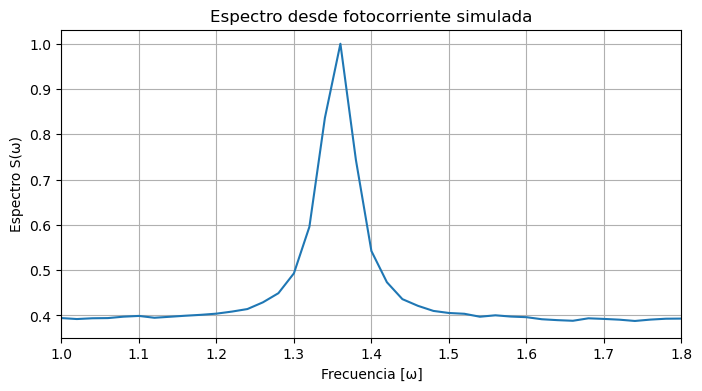

In [79]:
# Transformada de Fourier: S(ω) = ∫ dτ e^{iωτ} <I(t+τ) I(t)>
S_w = fftshift(fft(autocorr_pos))
freqs = fftshift(fftfreq(len(tau), dt))

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(freqs, np.real(S_w) / np.max(np.real(S_w)))
plt.xlabel("Frecuencia [ω]")
plt.ylabel("Espectro S(ω)")
plt.title("Espectro desde fotocorriente simulada")
plt.grid(True)
plt.axvline(x=Omega/(2*np.pi), color='r', linestyle='--', label=f'ω=±{Omega}')
plt.axvline(x=-Omega/(2*np.pi), color='r', linestyle='--')

plt.xlim(1,1.8)
plt.show()



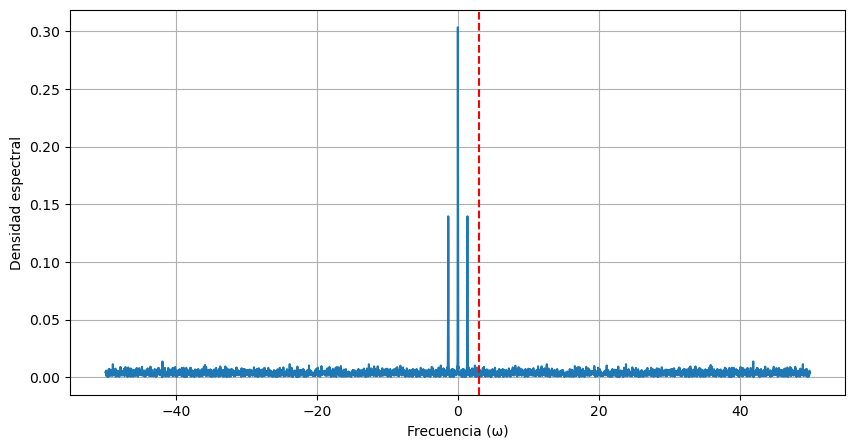

In [75]:
from scipy.signal import correlate
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt

# 1. Asegurar el tamaño correcto de la autocorrelación
signal_length = len(trajectories_I[0,:])  # Longitud de cada trayectoria
autocorr_size = 2*signal_length - 1  # Tamaño esperado de la autocorrelación completa
autocorr_total = np.zeros(autocorr_size, dtype=np.complex128)

for k in range(num_traj):
    I = trajectories_I[k, :].real  # Parte real de la fotocorriente
    I_centered = I - np.mean(I)  # Eliminar componente DC
    
    # Calcular autocorrelación asegurando el tamaño correcto
    autocorr = correlate(I_centered, I_centered, mode='full')
    
    # Verificar tamaños (debug)
    if len(autocorr) != autocorr_size:
        print(f"Advertencia: Trayectoria {k} tiene tamaño {len(autocorr)} (esperado {autocorr_size})")
        continue
    
    autocorr_total += autocorr

# 2. Promedio y normalización
autocorr_avg = autocorr_total / num_traj
lags = np.arange(-signal_length + 1, signal_length) * dt

# 3. Seleccionar retardos positivos
positive_lags = lags >= 0
tau = lags[positive_lags]
autocorr_pos = autocorr_avg[positive_lags] / autocorr_avg[positive_lags][0]  # Normalizada

# 4. Transformada de Fourier con ventana
window = np.hanning(len(autocorr_pos))
S_w = fftshift(fft(autocorr_pos * window))
freqs = fftshift(fftfreq(len(tau), dt))

# 5. Visualización (como antes)
plt.figure(figsize=(10,5))
plt.plot(freqs, np.abs(S_w))
plt.axvline(x=Omega, color='r', linestyle='--')
plt.xlabel('Frecuencia (ω)')
plt.ylabel('Densidad espectral')
plt.grid(True)

plt.show()

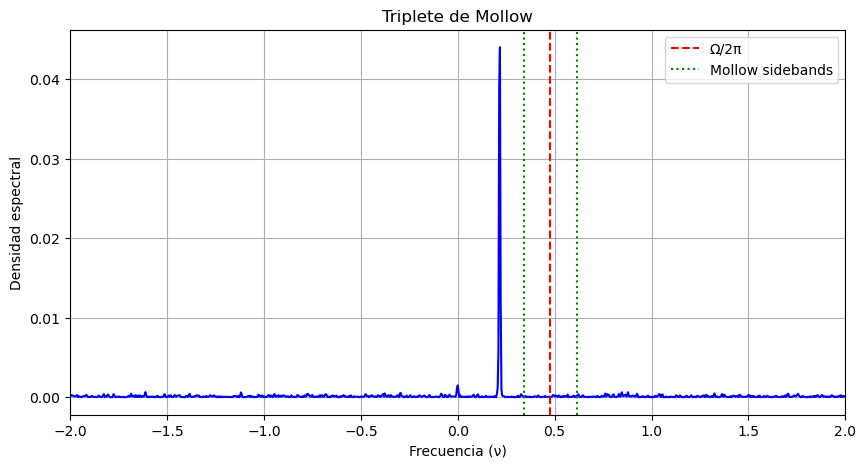

In [71]:
# Análisis espectral CORREGIDO
from scipy.signal import welch

# Usar solo la parte REAL de la fotocorriente
I_real = trajectories_I

# Promedio sobre trayectorias
I_avg = np.mean(I_real, axis=0)

# Calcular PSD con método de Welch
f, S = welch(I_avg, fs=1/dt, nperseg=4096, window='hann')

# Graficar
plt.figure(figsize=(10,5))
plt.plot(fftshift(f)/(2*np.pi), fftshift(S), 'b')  # Convertir a frecuencia cíclica
plt.axvline(x=Omega/(2*np.pi), color='r', ls='--', label='Ω/2π')
plt.axvline(x=(Omega + np.sqrt(3)*gamma/2)/(2*np.pi), color='g', ls=':', label='Mollow sidebands')
plt.axvline(x=(Omega - np.sqrt(3)*gamma/2)/(2*np.pi), color='g', ls=':')
plt.xlim(-2, 2)
plt.xlabel('Frecuencia (ν)')
plt.ylabel('Densidad espectral')
plt.legend()
plt.grid(True)
plt.title("Triplete de Mollow")
plt.show()